<a href="https://colab.research.google.com/github/ayami-n/Flax_text_prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Flax_text_prediction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Flax_text_prediction


# Import libs

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [2]:
# Jax
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp
import jax.tools.colab_tpu  # TPU Settings

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
    
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze
from flax import traverse_util
from flax.training.common_utils import shard, shard_prng_key, onehot

# Optax for optimizor 
import optax

# Transformers
!pip install transformers
from transformers import FlaxAutoModelForSequenceClassification, BertTokenizer, AutoConfig # as we use Roberta model
from transformers.modeling_flax_utils import FlaxPreTrainedModel  # FlaxMLPModule is still stateless

# others
import pandas as pd
from tqdm import tqdm
from typing import Callable, Any
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
!pip install datasets
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TPU Setting

In [3]:
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.79.31.162:8470


In [4]:
jax.tools.colab_tpu.setup_tpu()  # set up the Colab TPU for use with JAX
print("TPU: ", jax.devices())  # it will be 8 TpuDevices when TPU works correctly

TPU:  [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


## Data Analysis

In [5]:
df = pd.read_csv("./kaggle/train.csv")  # import train datasets
max = 0
max_str = "Who is Max?"
words_list = []

for itr, val in enumerate(df['discourse_text'].to_numpy()):
  words = val.split()
  words_list.append(len(words))

  if len(words) > max:
    max = len(words)
    max_str = val

print(pd.Series(list(filter(lambda x: (x <= 256), words_list))).count(), len(words_list))    

36566 36765


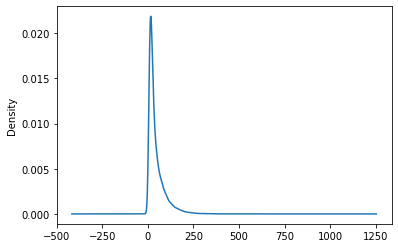

In [ ]:
'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.kde.html
'''
pd.Series(words_list).plot.kde()  # most words are less than 250

# Config

In [6]:
### Model Config ####
model_checkpoint = 'bert-base-cased' # https://huggingface.co/docs/transformers/model_doc/roberta#roberta: siebert/sentiment-roberta-large-english
seed = 0  # for building our model
num_labels=3
config = AutoConfig.from_pretrained(model_checkpoint, num_labels=num_labels)

tokenizer = BertTokenizer.from_pretrained(model_checkpoint, use_fast=True)  # this tokenizer converts numeric from string: the values are different if you select different model_checkpoint

### Train Config ####
num_train_epochs = 5
learning_rate = 2e-5
per_device_batch_size = 32
weight_decay=1e-2
total_batch_size = per_device_batch_size * jax.local_device_count()  # 32 * 8 TpuDevices = 256
print("Total Batch size {:d}" .format(total_batch_size))

Total Batch size 256


## Creating Dummy Inputs

In [11]:
train_df, val_df = train_test_split(df, test_size=0.05, random_state=seed)  # spliting datasets 95% train and 5% val

max_len = 128  # input text should be the same length (most words <= 256)

dummy = tokenizer(train_df['discourse_text'].to_numpy()[:1][0], # [:1][0] -> makes str
                  max_length=max_len, truncation=True, 
                  padding='max_length', 
                  ) # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)

dummy_input_ids, dummy_attention_mask = dummy['input_ids'], dummy['attention_mask']  # jax: the values (text) are converted by the tokenizer, the values (attention-mask) are converted by the tokenizer

In [ ]:
'''
https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt
adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence.
[CLS] I love you [SEP] is expected by BERT. 
tokenizer gives [CLS] and [SEP] usually
'''

In [ ]:
tokenizer.convert_ids_to_tokens(dummy_input_ids)[:30]  # checking the converted id's

# Tokenaization and Loading Data

In [7]:
data = load_dataset("csv", data_files={'train': ["./kaggle/train.csv"]})
data = data["train"].train_test_split(0.05)

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
def preprocess_function(input_batch):
   
    texts = (input_batch["discourse_text"],)
    processed = tokenizer(*texts, 
                          max_length=128, 
                          truncation=True, padding='max_length')     
    
    # replace label -> numerical
    processed["labels"] = input_batch["discourse_effectiveness"]
    new_label = {"Ineffective": 0, "Adequate": 1, "Effective": 2}
    processed["labels"] = [x if x not in new_label else new_label[x] for x in processed["labels"]]
    
    return processed

In [9]:
tokenized_dataset = data.map(preprocess_function, batched=True, remove_columns=data["train"].column_names)
train_dataset = tokenized_dataset["train"]
validation_dataset = tokenized_dataset["test"]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [10]:
def train_data_loader(rng, dataset, batch_size):
    # define random permutation for 8 tpuDevice
    steps_per_epoch = len(dataset) // batch_size  # 320000/(256)
    perms = jax.random.permutation(rng, len(dataset))  # shuffle
    perms = perms[: steps_per_epoch * batch_size]  # Skip incomplete batch.
    perms = perms.reshape((steps_per_epoch, batch_size))

    for perm in perms:
        batch = dataset[perm]
        batch = {k: jnp.array(v) for k, v in batch.items()}  # stack values
        batch = shard(batch) # for TPU
        yield batch  

In [11]:
def eval_data_loader(dataset, batch_size): 
    for i in range(len(dataset) // batch_size):  # 65536 // 256 = 7
        batch = dataset[i * batch_size : (i + 1) * batch_size] # create dict
        batch = {k: jnp.array(v) for k, v in batch.items()}  # stack values
        batch = shard(batch)  # for TPU 
        yield batch

# Create a model

In [12]:
# the model size is 1.32G
model = FlaxAutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config, seed=seed)  

Some weights of the model checkpoint at bert-base-cased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'scale'), ('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'bias')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased 

## Define the Training State

In [13]:
class TrainState(train_state.TrainState):
    logits_function: Callable = flax.struct.field(pytree_node=False)
    loss_function: Callable = flax.struct.field(pytree_node=False)

In [14]:
def decay_mask_fn(params):  # expect the params are unfreeze
    '''
    This function's task is to make sure that weight decay is not applies to any bias or Layernorm weights
    '''
    flat_params = traverse_util.flatten_dict(params)
    flat_mask = {path: (path[-1] != "bias" and path[-2:] != ("LayerNorm", "scale")) for path in flat_params}
    return traverse_util.unflatten_dict(flat_mask)

In [15]:
# Adam optimizer function using optax.adamw
def adamw(weight_decay):
    return optax.adamw(learning_rate=learning_rate_function, b1=0.9, b2=0.999, eps=1e-6, weight_decay=weight_decay,mask=decay_mask_fn)

In [16]:
num_train_steps = len(train_dataset) // total_batch_size * num_train_epochs
learning_rate_function = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=learning_rate, pct_start=0.1)
adamw = adamw(weight_decay)

# Define Loss and Accuracy Functions

In [17]:
@jax.jit
def cross_entropy_loss(logits, labels):  # loss: softmax
  # labels_onehot = jax.nn.one_hot(labels, num_classes=num_labels)
  return jnp.mean(optax.softmax_cross_entropy(logits, onehot(labels, num_classes=num_labels)))   # return example: 0.96834594

In [18]:
@jax.jit
def eval_function(logits):
  return logits.argmax(-1) # accuracy

In [19]:
state = TrainState.create(
    apply_fn=model.__call__,
    params=model.params,
    tx=adamw, 
    logits_function=eval_function,
    loss_function=cross_entropy_loss,
)

# Define the Training/Evaluation Steps

In [20]:
def train_step(state, batch, dropout_rng):  # softmax
  labels = batch.pop("labels")
  dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

  def compute_loss(params): # warp with jax.value_and_grad
    logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]  # **batch = input_ids, attention_mask
    loss = state.loss_function(logits, labels)
    return loss

  # do the forward pass and get the loss and gradients
  grad_function = jax.value_and_grad(compute_loss)  # def loss_function(params) is wrapped by Jax to calculate loss and gradient
  loss, grad = grad_function(state.params)

  grad = jax.lax.pmean(grad, "batch") # compute the mean gradient over all devices 

  # this function calls tx.update() followed by a call to optax.apply_updates() to update params and opt_state
  new_state = state.apply_gradients(grads=grad)  # update params with Adam  

  # calculate accuracy and store loss and accuracy
  # accuracy = argmax_logits(logits=logits, labels=labels) 
  new_metrics = {'train_loss': loss} # , 'train_accuracy': accuracy}
  
  return new_state, new_metrics, new_dropout_rng

In [21]:
parallel_train_step = jax.pmap(train_step, axis_name="batch", donate_argnums=(0,)) # parallelized training over all TPU devices

In [22]:
def eval_step(state, batch):  # argmax
    logits = state.apply_fn(**batch, params=state.params, train=False)[0]
    return state.logits_function(logits=logits)  # return loss and accuracy

In [23]:
parallel_eval_step = jax.pmap(eval_step, axis_name="batch")

# Training

In [27]:
# Full training loop
state = flax.jax_utils.replicate(state)  # sharing the weight on each device
rng = jax.random.PRNGKey(seed)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

for i, epoch in enumerate(tqdm(range(1, num_train_epochs + 1), desc=f"Epoch ...", position=0, leave=True)):
    rng, input_rng = jax.random.split(rng)

    # train
    with tqdm(total=len(train_dataset) // total_batch_size, desc="Training...", leave=False) as progress_bar_train:
        for batch in train_data_loader(input_rng, train_dataset, total_batch_size):
            state, train_metrics, dropout_rngs = parallel_train_step(state, batch, dropout_rngs)
            progress_bar_train.update(1)

    # evaluate
    # with tqdm(total=len(validation_dataset) // total_batch_size, desc="Evaluating...", leave=False) as progress_bar_eval:
    #       for batch in eval_data_loader(validation_dataset, total_batch_size):
    #             labels = batch.pop("labels")
    #             predictions = parallel_eval_step(state, batch)
    #             metric.add_batch(predictions=chain(*predictions), references=chain(*labels))
    #             progress_bar_eval.update(1)

    # eval_metric = metric.compute(average='macro')

    # loss = round(flax.jax_utils.unreplicate(train_metrics)['loss'].item(), 3)
    # eval_score = round(list(eval_metric.values())[0],3)
    # metric_name = list(eval_metric.keys())[0]

    # print(f"{i+1}/{num_train_epochs} | Train loss: {loss} | Eval {metric_name}: {eval_score}")

Epoch ...: 100%|██████████| 5/5 [48:58<00:00, 587.78s/it]


In [ ]:
rng = jax.random.PRNGKey(seed)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

for batch in eval_data_loader(validation_dataset, total_batch_size):
    labels = batch.pop("labels")
    predictions = eval_step(state, batch)
    print(predictions)
    # metric.add_batch(predictions=chain(*predictions), references=chain(*labels))
    # progress_bar_eval.update(1)
    break

# Future Study

In [ ]:
class MyNLP(nn.Module):
    roberta: nn.Module
     
    @nn.compact
    def __call__(self, input_ids, attention_mask, train=True, dropout_rng=None):  # https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ 
        out = self.roberta(input_ids, attention_mask, output_hidden_states=True, dropout_rng=dropout_rng)  # extract all hidden layers: but we need the last (attention) layer, in particular, [CLS]  
        cls_embedding = out.hidden_states[0][:,0,:] # (1, 1024): [:,0,:] -> first : is all sentences, 0 is [CLS], last : is all hidden unit outputs
        
        #### Transfer Learning: name should be alpabet orders for the summary ####
        out = nn.Dense(features=512, name="A")(out)  
        out = nn.Dense(features=256, name="B")(out)

        out = nn.Dropout(0.1, deterministic=True, name='C')(out)  # deteministic=true: no mask and apply the rate

        out = nn.Dense(features=64, name="D")(out)
        out = nn.Dense(features=3, name="E")(out)

        return out
        
num_train_steps = len(train_dataset) // total_batch_size * num_train_epochs
print("Number of Train Steps {:d}" .format(num_train_epochs))

learning_rate_function = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=learning_rate, pct_start=0.1)

### initialize the model ###
init_rng = jax.random.PRNGKey(seed)

# model = MyNLP(pretrained_roberta)  # create a model
model = MyNLP(pretrained_bert)
print(model.tabulate(init_rng, dummy_input_ids, dummy_attention_mask))  # display the summary
variables = model.init(init_rng, dummy_input_ids, dummy_attention_mask)  # store only [A-E] variables

#### add randomly initialized params with pretrained params ####
variables = unfreeze(variables)  # unfreeze: Makes a mutable copy of a FrozenDict mutable by transforming it into (nested) dict
variables['params']['RoberTa'] = pretrained_roberta.params  # inserting the pretrained parameters into the correct place on the new parameter structure as names will matter 
# variables = freeze(variables)  # freeze: An immutable variant of the Python dict.

# opt = optax.adam(2e-5)
opt = adamw(weight_decay)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=opt
    )        